In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pydeseq2.preprocessing import deseq2_norm

In [2]:
def create_groups(metadata, col, principalComponents):
    condition_list = metadata[col].to_list()
    
    # Group data points by conditions for PCA plot labeling
    groups = {}
    for i, label in enumerate(condition_list):
        if label not in groups:
            groups[label] = []
        groups[label].append(principalComponents[i])
    
    return groups

def run_PCA(df, standardize, n_components, metadata, plot_title, normalization_method, save_dir):
    """
    For quick use of PCA to asses normalization results of different normalization steps
    
    :param df: a pandas dataframe that has samples as columns and genes as rows
    :param standardize: whether to standardize the counts before pca, can be either True or False
    :param n_components: number of components for PCA, data type:int
    :param metadata: metadata is a dataframe that has samples as rows, "condition, sex, age, batch" as columns
    :param plot_title: title for saving PCA results, data type:str
    :param normalization_method: normalization method will only be used for plot save_name annotation, data type: str
    
    :return: none
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    
    # Drop NaN for PCA
    df = df.dropna()
    print(f"{len(df.index)} features are kept are NaN Removal")
    
    # Standardize the data for PCA
    if standardize == True:
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df.T)
    elif standardize == False:
        df_scaled = df
    else:
        print('standardise not defined, True or False is needed')
    
    # Run pca
    print(f'Running PCA with n_componenets={n_components}')
    pca = PCA(n_components=n_components)  
    principalComponents = pca.fit_transform(df_scaled)
    
    # Plot individual 
    plt.figure(figsize=(8, 6))
    for i in range(principalComponents.shape[0]):
        plt.scatter(principalComponents[i, 0], principalComponents[i, 1], alpha=0.7)  # Plot each point
        plt.annotate(df.columns[i],  
                     (principalComponents[i, 0], principalComponents[i, 1]),  
                     textcoords="offset points",  
                     xytext=(5,5),  
                     ha='center')  

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(plot_title)
    plt.savefig(save_dir + normalization_method + '_colored_by_sample_id.pdf')
    plt.show()
    
    # Plot colored by group
    groups = create_groups(metadata = metadata, col = 'condition', principalComponents=principalComponents)
    
    import matplotlib.patches as patches
    from scipy.stats import chi2

    plt.figure(figsize=(8, 6))

    # Define a color for each group
    group_colors = {'Male_Young': 'blue', 'Control': 'yellow', 'Male_Old': 'green', 'Female_Young': 'red', 'Female_Old': 'orchid'}

    for label, group in groups.items():
        group = np.array(group)
        group = group[:,:2]
        color = group_colors[label]
    
        # Scatter plot for the group
        plt.scatter(group[:, 0], group[:, 1], alpha=0.7, label=label)

        # Calculate the mean and covariance
        group_mean = np.mean(group, axis=0)
        group_cov = np.cov(group, rowvar=False)

        # Calculate the width, height, and angle for the ellipse
        lambda_, v = np.linalg.eig(group_cov)
        ## Determine scale for 95% confidence
        k = np.sqrt(chi2.ppf(0.95, 2))
        lambda_2sqrt = 2 * k * np.sqrt(lambda_)
        ell_width, ell_height = lambda_2sqrt[0], lambda_2sqrt[1]
        angle = np.rad2deg(np.arctan2(*v[:,0][::-1]))

        # Create an Ellipse patch
        ell = patches.Ellipse((group_mean[0], group_mean[1]), ell_width, ell_height, angle=angle, edgecolor=color, facecolor=color, alpha=0.3)
    
        # Add the Ellipse to the plot
        plt.gca().add_patch(ell)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(plot_title)
    plt.legend()
    plt.savefig(save_dir + normalization_method + '_colored_by_condition.pdf')
    plt.show()
    
    
    # Plot colored by batch
    batches = create_groups(metadata = metadata, col = 'batch', principalComponents=principalComponents)
    
    plt.figure(figsize=(8, 6))
    for label, batch in batches.items():
        batch = np.array(batch)
        plt.scatter(batch[:, 0], batch[:, 1], alpha=0.7, label=label)
    
    for i in range(principalComponents.shape[0]):
        plt.annotate(df.columns[i],  
                    (principalComponents[i, 0], principalComponents[i, 1]),  
                    textcoords="offset points",  
                    xytext=(5,5),  
                    ha='center')  

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(plot_title)
    plt.legend()
    plt.savefig(save_dir + normalization_method + '_colored_by_batch.pdf')
    plt.show()
    
    return

In [3]:
counts_path = './1.Count/'

df = pd.read_excel(counts_path + 'gene_count.xlsx')

In [4]:
# re-format the dataframes to put gene_name as rownames (indexes)

def NameRows_Gene(df):
    df_data = df.iloc[: , 1:]
    df_label = df['gene_id']
    df_data.index = df_label
    return df_data

df = NameRows_Gene(df)
df

,MY1_1,MY1_2,MY1_3,MY1_ctrl,Fat_OM1_1,Fat_OM1_2,Fat_OM1_3,YF1_1,YF1_Ctrl,OF1_1,OF1_4,OF1_FY2_ctrl,OF2_1,OF2_2,OF2_4,OF2_ctrl,FY2_1,FY2_3
gene_id,,,,,,,,,,,,,,,,,,
ENSG00000087086,650775,1006740,782492,418678,430234,398159,358284,665614,441232,672444,373510,481789,712699,681253,838003,595407,595624,479740
ENSG00000099194,390924,829454,441286,201239,331301,326124,310017,314474,236898,337333,84930,405597,844178,642285,647883,349947,462090,173527
ENSG00000198886,367852,561842,338677,248266,137996,164048,173474,304420,216935,352173,121569,349281,397256,253819,384472,360596,341003,177595
ENSG00000198804,316994,428352,229208,360154,193141,221580,241880,267061,194723,286602,60835,284787,408146,226503,319392,357269,263981,108717
ENSG00000198763,158843,276268,220187,224258,125876,115018,97678,180032,143926,232737,104988,235900,209121,161997,260111,194547,223026,130330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000276351,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000275661,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000277856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# Build a dataframe with sample-condition annotation (serving as metadata for DESeq2)
conditions_annotate = {'MY1_1':'Male_Young', 'MY1_2':'Male_Young', 'MY1_3':'Male_Young', 'MY1_ctrl':'Control',
                       'Fat_OM1_1':'Male_Old', 'Fat_OM1_2':'Male_Old', 'Fat_OM1_3':'Male_Old', 
                       'YF1_1':'Female_Young', 'YF1_Ctrl':'Control',
                       'OF1_1':'Female_Old', 'OF1_4':'Female_Old', 'OF1_FY2_ctrl':'Control',
                       'OF2_1':'Female_Old', 'OF2_2':'Female_Old', 'OF2_4':'Female_Old', 'OF2_ctrl':'Control',
                       'FY2_1':'Female_Young', 'FY2_3':'Female_Young'
                       }

condition_metadata = pd.Series(conditions_annotate)
metadata = pd.DataFrame(condition_metadata)
metadata.columns = ['condition']

# Add sex as another design factor in addition to condition for future DE analysis
sex_list = ['Male','Male','Male','Control','Male','Male','Male','Female','Control','Female','Female','Control','Female',
           'Female','Female','Control','Female','Female']
metadata['sex'] = sex_list

# Add sex as another design factor for future DE analysis
age_list = ['Young','Young','Young','Control','Old','Old','Old','Young','Control','Old','Old','Control','Old','Old',
           'Old','Control','Young','Young']
metadata['age'] = age_list

# Add batch as another design factor for future DE analysis
batch_list = ['Batch_1'] * 7 + ['Batch_2'] * 2 + ['Batch_3'] * 3 + ['Batch_4'] * 4 + ['Batch_3'] * 2
metadata['batch'] = batch_list

In [6]:
metadata

,condition,sex,age,batch
MY1_1,Male_Young,Male,Young,Batch_1
MY1_2,Male_Young,Male,Young,Batch_1
MY1_3,Male_Young,Male,Young,Batch_1
MY1_ctrl,Control,Control,Control,Batch_1
Fat_OM1_1,Male_Old,Male,Old,Batch_1
Fat_OM1_2,Male_Old,Male,Old,Batch_1
Fat_OM1_3,Male_Old,Male,Old,Batch_1
YF1_1,Female_Young,Female,Young,Batch_2
YF1_Ctrl,Control,Control,Control,Batch_2
OF1_1,Female_Old,Female,Old,Batch_3


58735 features are kept are NaN Removal
Running PCA with n_componenets=4


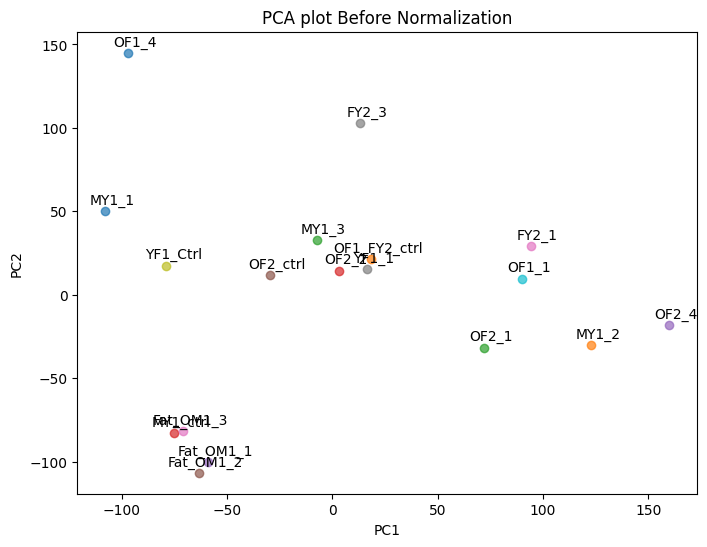

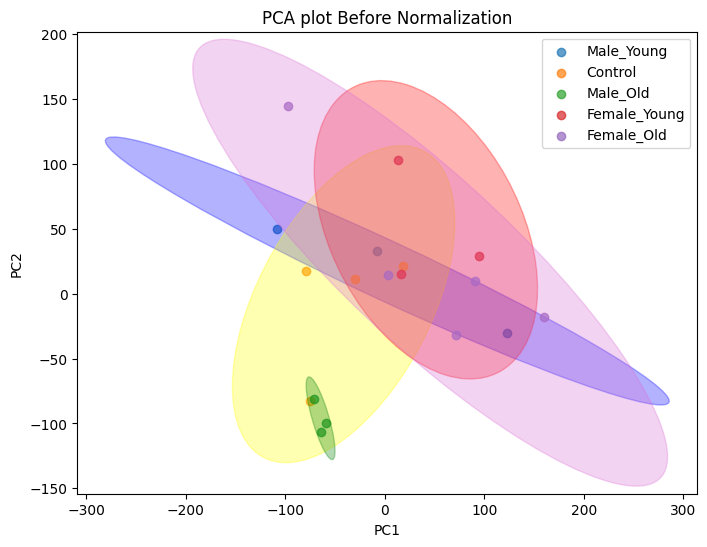

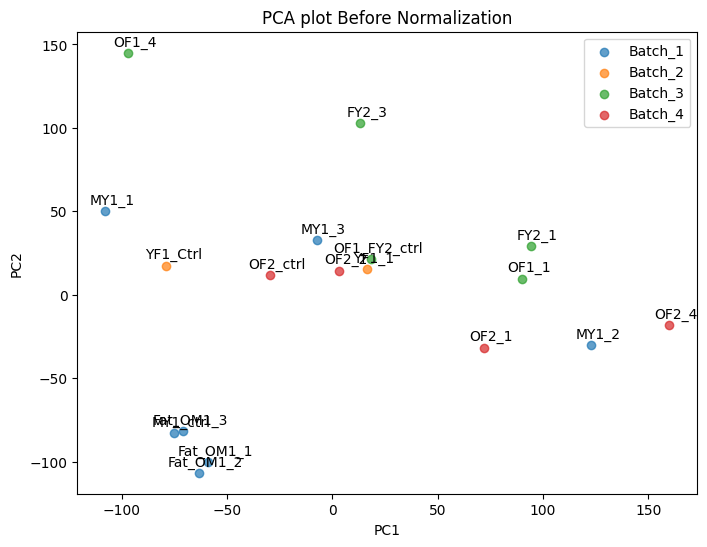

In [7]:
# Run run_PCA to assess sample variation before any normalization
PCA_save_dir = '/Volumes/Elements/20240122_Old_Young_serum_RNAseq_novogene/Results_Yuchen_MOR_BatchNormalization/0_PCA/'

run_PCA(df=df, standardize=True, n_components=4, 
        metadata = metadata,
        plot_title='PCA plot Before Normalization',
        normalization_method='Raw',
        save_dir = PCA_save_dir)

In [8]:
# Perform median of ratios normalization (default method of DESeq2)
norm = deseq2_norm(df.T)
norm_df = norm[0].T

# Normalized Counts save_dir
Normalized_counts_save_dir = '/Volumes/Elements/20240122_Old_Young_serum_RNAseq_novogene/Results_Yuchen_MOR_BatchNormalization/1_Normalized_Counts/'
norm_df.to_excel(Normalized_counts_save_dir + '1_Median_of_Ratios_normalized_counts_All_sample.xlsx')

58735 features are kept are NaN Removal
Running PCA with n_componenets=4


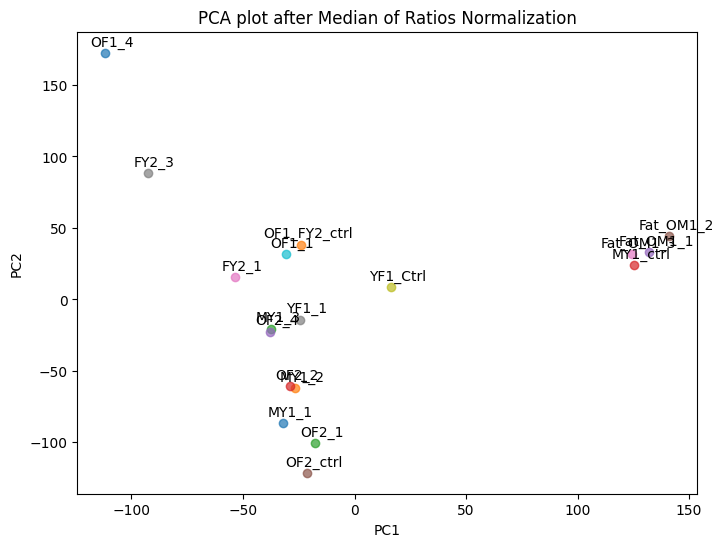

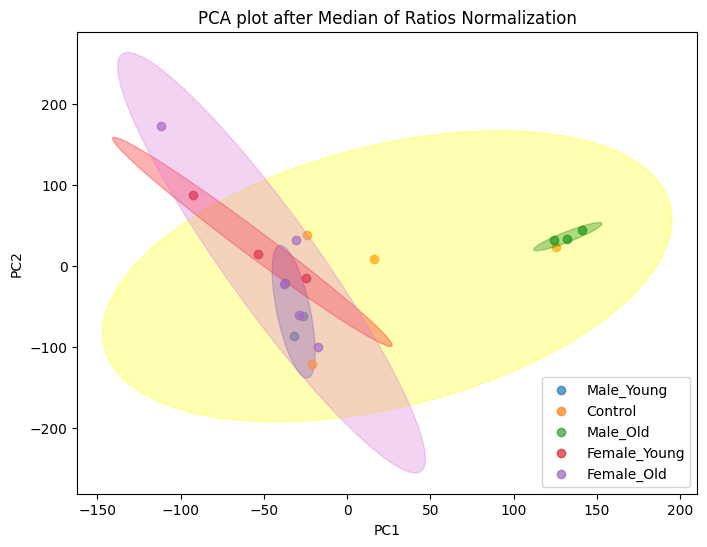

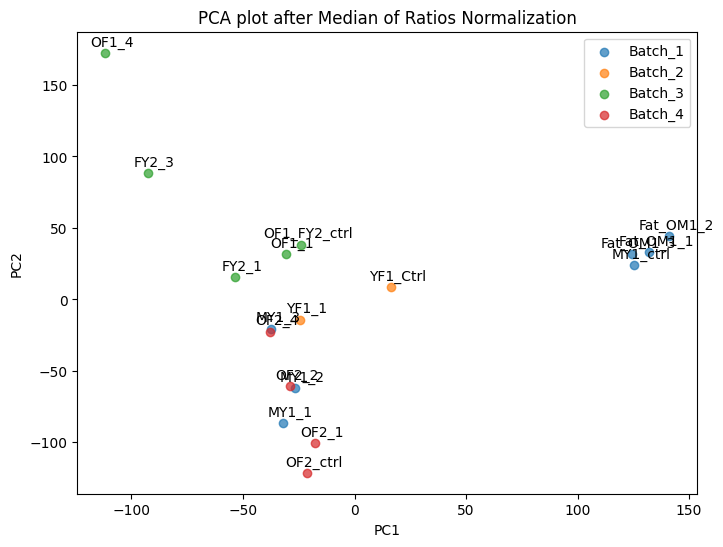

In [9]:
run_PCA(df=norm_df, standardize=True, n_components=4, 
        metadata = metadata,
        plot_title='PCA plot after Median of Ratios Normalization',
        normalization_method='Median_of_Ratios',
        save_dir = PCA_save_dir)

In [10]:
# Normalize the sample counts to control of each batch 

def normalize_to_control(df, metadata):
    import pandas as pd
    import numpy as np
    
    # Extract batch info from metadata
    unique_batch = metadata['batch'].unique()
    unique_batch_list = list(unique_batch)
    
    All_control_df = pd.DataFrame()
    normalized_df = df
    
    for i in unique_batch_list:
        mask = metadata['batch'] == i 
        filtered_df = normalized_df.loc[:, mask] 
        filtered_metadata = metadata[mask] 
        control_mask = filtered_metadata['condition'] == 'Control' 
        control_df = filtered_df.loc[:, control_mask] 
        All_control_df = pd.concat([All_control_df, control_df], axis=1, ignore_index=False) 

        for j in normalized_df.columns:
            if metadata.loc[j,'batch'] == i:
                normalized_df[j] = normalized_df[j]/control_df.iloc[:,-1]
    
    control_mean = All_control_df.mean(axis=1)
    normalized_mul_df = normalized_df.multiply(control_mean, axis=0)
    
    return normalized_mul_df

In [11]:
norm_df = normalize_to_control(df=norm_df, metadata=metadata)
norm_df

,MY1_1,MY1_2,MY1_3,MY1_ctrl,Fat_OM1_1,Fat_OM1_2,Fat_OM1_3,YF1_1,YF1_Ctrl,OF1_1,OF1_4,OF1_FY2_ctrl,OF2_1,OF2_2,OF2_4,OF2_ctrl,FY2_1,FY2_3
gene_id,,,,,,,,,,,,,,,,,,
ENSG00000087086,1.034906e+06,920560.351240,923667.132850,514828.484689,506222.617538,469430.798675,441304.376441,629441.870732,514828.484689,625826.542059,533641.310531,514828.484689,499172.956678,544778.188922,497778.804657,514828.484689,565976.899287,539334.591277
ENSG00000099194,7.860097e+05,958943.083243,658599.379757,312867.290555,492861.786996,486142.272557,482794.054607,336605.437103,312867.290555,226629.491022,87592.731965,312867.290555,611347.561345,531065.780351,397920.823264,312867.290555,316966.107356,140824.799898
ENSG00000198886,5.924874e+05,520337.568320,404908.905409,309197.315191,164452.074042,195894.400865,216411.957415,351655.071169,309197.315191,271524.471492,143888.179384,309197.315191,275918.958806,201280.447951,226475.757907,309197.315191,268435.395858,165401.005001
ENSG00000198804,3.601900e+05,279863.603833,193319.666708,316432.695954,162376.050741,186662.158098,212873.432035,351732.246079,316432.695954,277352.813061,90376.646789,316432.695954,292818.040079,185533.624045,194335.546699,316432.695954,260828.287209,127088.223074
ENSG00000198763,1.922501e+05,192262.274492,197813.446258,209874.136475,112721.900213,103207.059574,91566.397825,212768.331437,209874.136475,180338.553125,124885.542483,209874.136475,182737.760805,161623.314291,192768.158383,209874.136475,176444.167009,121989.382717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000276351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000275661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000277856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Save within batch normalized counts
norm_df.to_excel(Normalized_counts_save_dir + '2_within_batch_normalized_after_MOR_counts_All_sample.xlsx')

16548 features are kept are NaN Removal
Running PCA with n_componenets=4


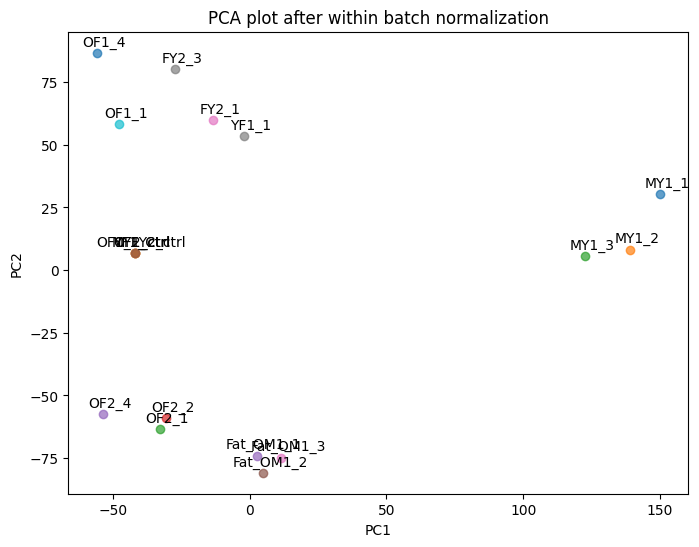

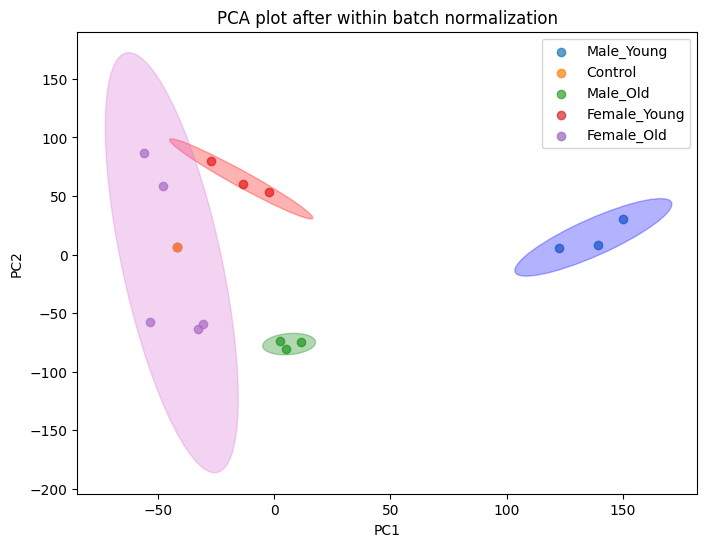

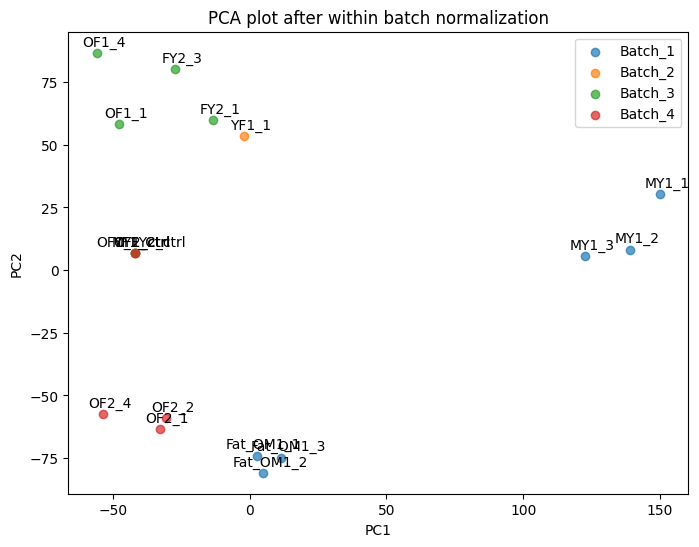

In [13]:
run_PCA(df=norm_df, standardize=True, n_components=4, 
        metadata = metadata,
        plot_title='PCA plot after within batch normalization',
        normalization_method='Within_batch_normalized',
        save_dir = PCA_save_dir)

In [15]:
metadata.to_excel(Normalized_counts_save_dir + 'metadata.xlsx')

In [19]:
# Save median of ratios size factors for future use
np.savetxt(Normalized_counts_save_dir+'SizeFactor.csv', norm[1], delimiter=',')